<div align="center">
<h1 style="color:#1565c0; font-size:2.8em; font-weight:bold; margin-bottom:0.2em; margin-top:0.5em;">Практична робота №2</h1>
<h3 style="color:#1976d2; margin-top:0; font-weight:normal;">Побудова та оцiнювання якостi
моделей класифiкацiї та регресiї засобами бiблiотеки <b>Scikit-Learn Python</b></h3>
<br>
<br>
<b>Варіант 12</b><br>
<b>Автори:</b><br>
Плахтій Злата, КА-32<br>
Пастушенко Максим, КА-33<br>
Романов Фелікс, КА-33
</div>

<b>Мета:</b> Метою роботи є побудова та оцiнювання якостi моделей:
- дерев рiшень,
- опорних векторiв,
- логiстичної регресiї,
- наївної баєсiвської моделi
для класифiкацiї та регресiї засобами бiблiотеки Scikit-Learn Python.

<b>Хід роботи:</b>
1. Підготувати дані.
2. Представити початкових даних графiчно.
3. Розбити данi на навчальний та валiдацiйний набори.
4. Побудувати на навчальному наборi даних моделi класифiкацiї або регресiї заданi згiдно з варiантом.
4. Представити моделi графiчно (наприклад вивести частину дерева рiшень, побудувати лiнiю регресiї тощо).
5. Виконати прогнози на основi побудованих моделей.
6. Для кожної з моделей оцiнити, чи має мiсце перенавчання.
7. В задачах регресiї розрахувати для кожної моделi наступнi критерiї якостi, окремо на навчальнiй та валiдацiйнiй множинах:

    • коефiцiєнт детермiнацiї R2,
    
    • помилки RMSE, MAE та MAPE.

8. Спробувати виконати решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей.
9. Зробити висновки про якiсть роботи моделей на дослiджених даних. На
основi критерiїв якостi спробувати обрати найкращу модель.
10. Навчити моделi на пiдмножинах навчальних даних. Оцiнити, наскiльки
розмiр навчальної множини впливає на якiсть моделi.
11. Кожний варiант мiстить два набори даних. Дослiдити обидва набори за
наведеними вище етапами.

<b>Завдання:</b><br>
Побудувати моделi регресiї на основi методу опорних векторiв:<br><br>
• Моделi нелiнiйної регресiї SVR(kernel="poly") з полiномiальним ядром. <br>
  Розглянути полiноми рiзного ступеня degree та рiзнi комбiнацiї гiперпараметрiв epsilon i C, наприклад: epsilon=0.1 i C=0.01; epsilon=0.1 i C=100.<br><br>
• Настроїти гiперпараметри epsilon i C, використовуючи решітчастий пошук.<br><br>
Початковi данi:<br>
(б) [avocado_prices.csv](https://www.kaggle.com/datasets/neuromusic/avocado-prices)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

In [18]:
# ------------------------------
# 1.1. Завантаження та огляд даних
# ------------------------------

# Load
df = pd.read_csv('data/avocado.csv')
df.columns = df.columns.str.strip()

# Header
print(f"Rows: {df.shape[0]:,}  |  Cols: {df.shape[1]:,}  |  Memory: {df.memory_usage(deep=True).sum()/1024**2:.3f} MB")
print("Columns:", ", ".join(df.columns))

# Types + non-null + unique (compact)
info = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "unique": df.nunique(dropna=False)
})
print("\nTypes / non-null / unique:")
print(info.to_string())

# Quick peek
print("\nHead:")
print(df.head().to_string(index=False))

# Numeric descriptive (compact)
num = df.select_dtypes(include=[np.number])
if not num.empty:
    print("\nNumeric summary:")
    print(num.describe().T.loc[:, ["count","mean","std","min","50%","max"]].to_string(float_format="{:,.3f}".format))

# Missing values
miss = df.isna().sum()
miss = miss[miss>0].sort_values(ascending=False)
print("\nMissing values:")
if miss.empty:
    print("  None")
else:
    pct = (miss/len(df)*100).round(2)
    for c in miss.index:
        print(f"  {c}: {miss[c]} ({pct[c]}%)")

# Duplicates
dups = df.duplicated().sum()
print(f"\nDuplicate rows: {dups}")
if dups:
    print("  First duplicates:")
    print(df[df.duplicated(keep='first')].head(3).to_string(index=False))

# Date parsing
if 'Date' in df.columns:
    parsed = pd.to_datetime(df['Date'], errors='coerce')
    bad = parsed.isna().sum()
    print(f"\nDate column: original dtype={df['Date'].dtype}, parse_failures={bad}")
    if bad==0:
        print(f"  Date range: {parsed.min().date()} — {parsed.max().date()}")
    else:
        print("  Example unparsable Date values:")
        print(df.loc[parsed.isna(), 'Date'].drop_duplicates().head(5).to_string(index=False))

# Quick numeric sanity checks
neg = [(c,int((df[c]<0).sum())) for c in num.columns if (df[c]<0).any()]
if neg:
    print("\nNegative values found:")
    for c,n in neg:
        print(f"  {c}: {n}")
else:
    print("\nNo negative values in numeric columns (quick check).")

Rows: 18,249  |  Cols: 14  |  Memory: 4.609 MB
Columns: Unnamed: 0, Date, AveragePrice, Total Volume, 4046, 4225, 4770, Total Bags, Small Bags, Large Bags, XLarge Bags, type, year, region

Types / non-null / unique:
                dtype  non_null  unique
Unnamed: 0      int64     18249      53
Date           object     18249     169
AveragePrice  float64     18249     259
Total Volume  float64     18249   18237
4046          float64     18249   17702
4225          float64     18249   18103
4770          float64     18249   12071
Total Bags    float64     18249   18097
Small Bags    float64     18249   17321
Large Bags    float64     18249   15082
XLarge Bags   float64     18249    5588
type           object     18249       2
year            int64     18249       4
region         object     18249      54

Head:
 Unnamed: 0       Date  AveragePrice  Total Volume    4046      4225   4770  Total Bags  Small Bags  Large Bags  XLarge Bags         type  year region
          0 2015-12-27    

In [19]:
# ------------------------------
# 1.2. Data Preparation
# ------------------------------

# Drop unnecessary columns
drop_candidates = ['Unnamed: 0', 'Unnamed:0', 'year']
drop_cols = [c for c in drop_candidates if c in df.columns]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)
    print('\nDropped utility columns:', drop_cols)
    
# Convert 'Date' column to datetime type
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    print("\nConverted 'Date' to datetime. Null dates found:", df['Date'].isnull().sum())

    # If there are nulls in 'Date', they can be dropped
    if df['Date'].isnull().any():
        n_dt = df['Date'].isnull().sum()
        df = df[~df['Date'].isnull()]
        print(f"Dropped {n_dt} rows with invalid Date.")

    # --- Feature Engineering from Date ---
    # year, month, week
    df['year'] = df['Date'].dt.year
    # month as integer (1-12)
    df['month'] = df['Date'].dt.month
    # ISO week (pandas >= 1.1 returns an isocalendar DataFrame)
    try:
        df['week'] = df['Date'].dt.isocalendar().week.astype(int)
    except Exception:
        # compatibility with older pandas versions
        df['week'] = df['Date'].dt.week.astype(int)

    # cyclical encoding for month (recommended for seasonality)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    # ------------------------------------------

# Rename PLU columns
rename_map = {}
for c in ['4046', '4225', '4770']:
    if c in df.columns:
        rename_map[c] = f'PLU_{c}'
if rename_map:
    df = df.rename(columns=rename_map)
    print("\nRenamed columns:", rename_map)

# Remove complete duplicate rows
dup_count = df.duplicated().sum()
if dup_count:
    df = df.drop_duplicates()
print(f"\nRemoved {dup_count} duplicate rows (if any).")

# Encode categorical features (type -> binary; region -> frequency encoding later)
# type conventional -> 0, organic -> 1
if 'type' in df.columns:
    
    # normalize strings to handle different cases
    df['type'] = df['type'].astype(str).str.strip().str.lower()
    type_map = {'conventional': 0, 'organic': 1}
    
    # Check for unexpected values that won't be mapped
    other_vals = set(df['type'].unique()) - set(type_map.keys())
    if other_vals:
        print("Warning: unexpected values in 'type':", other_vals)
    df['type'] = df['type'].map(type_map)
    
    # If mapping resulted in nulls (due to unexpected values), drop them
    if df['type'].isnull().any():
        n = df['type'].isnull().sum()
        df = df[~df['type'].isnull()]
        print(f"Dropped {n} rows with unmapped 'type' values.")

# Final check of data types
print("\nDtypes after preprocessing:\n", df.dtypes)
print("Shape:", df.shape)

# Save the prepared data
SAVE_PATH = 'data/avocado_prepared.csv'
df.to_csv(SAVE_PATH, index=False)
print(f"\nPreprocessing complete. Data saved to: {SAVE_PATH}")
print('\nShape after preparation:', df.shape)
print(df.head())


Dropped utility columns: ['Unnamed: 0', 'year']

Converted 'Date' to datetime. Null dates found: 0

Renamed columns: {'4046': 'PLU_4046', '4225': 'PLU_4225', '4770': 'PLU_4770'}

Removed 0 duplicate rows (if any).

Dtypes after preprocessing:
 Date            datetime64[ns]
AveragePrice           float64
Total Volume           float64
PLU_4046               float64
PLU_4225               float64
PLU_4770               float64
Total Bags             float64
Small Bags             float64
Large Bags             float64
XLarge Bags            float64
type                     int64
region                  object
year                     int32
month                    int32
week                     int64
month_sin              float64
month_cos              float64
dtype: object
Shape: (18249, 17)

Preprocessing complete. Data saved to: data/avocado_prepared.csv

Shape after preparation: (18249, 17)
        Date  AveragePrice  Total Volume  PLU_4046   PLU_4225  PLU_4770  \
0 2015-12-27    

In [20]:

# ------------------------------
# 2.1. Візуалізація даних
# ------------------------------

# Завантажити підготовлений файл 
df = pd.read_csv('data/avocado_prepared.csv', parse_dates=['Date'])

# Ensure Date and month
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if 'month' not in df.columns and 'Date' in df.columns:
    df['month'] = df['Date'].dt.month

# Prepare type labels
types_sorted = sorted(df['type'].dropna().unique()) if 'type' in df.columns else []
labels = {0: 'conventional', 1: 'organic'}



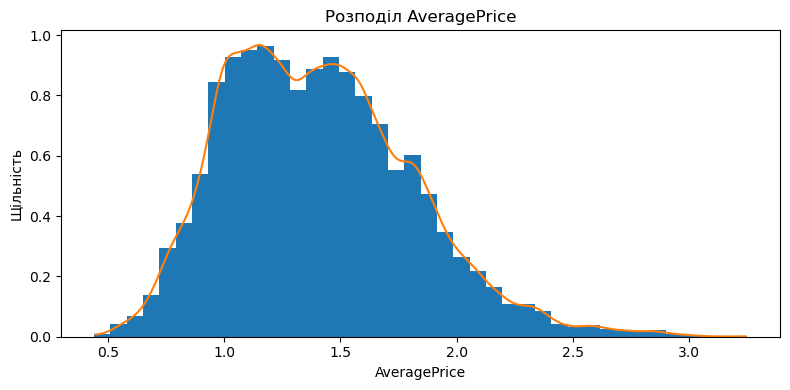

In [21]:
# Розподіл AveragePrice

plt.figure(figsize=(8,4))
vals_series = df['AveragePrice'].dropna()
plt.hist(vals_series, bins=40, density=True)
vals, bins = np.histogram(vals_series, bins=200, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, gaussian_filter1d(vals, sigma=3))
plt.title('Розподіл AveragePrice')
plt.xlabel('AveragePrice')
plt.ylabel('Щільність')
plt.tight_layout()
plt.show()

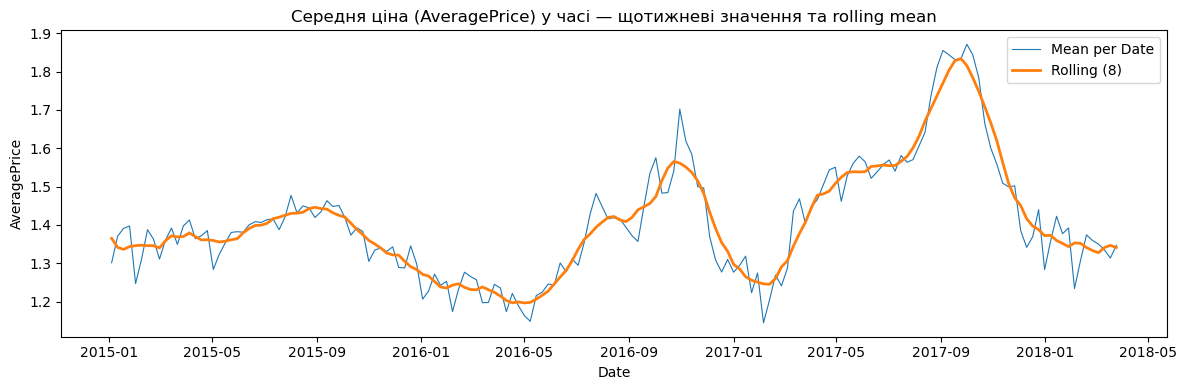

In [22]:
# AveragePrice протягом часу

plt.figure(figsize=(12,4))
price_by_date = df.groupby('Date')['AveragePrice'].mean()
plt.plot(price_by_date.index, price_by_date.values, linewidth=0.8, label='Mean per Date')
rolling = price_by_date.rolling(window=8, center=True, min_periods=1).mean()
plt.plot(rolling.index, rolling.values, linewidth=2, label='Rolling (8)')
plt.title('Середня ціна (AveragePrice) у часі — щотижневі значення та rolling mean')
plt.xlabel('Date')
plt.ylabel('AveragePrice')
plt.legend()
plt.tight_layout()
plt.show()

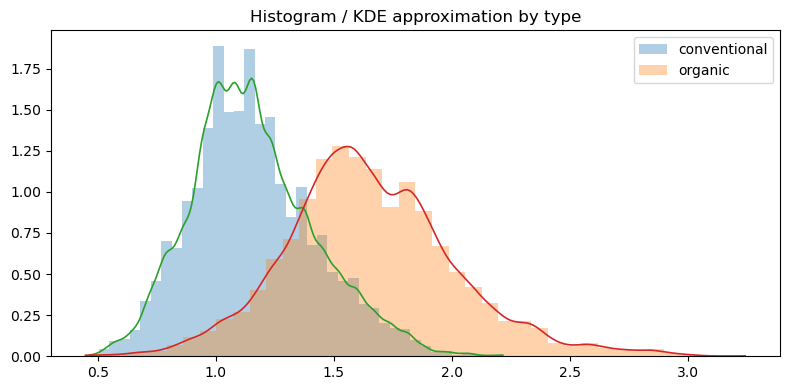

In [23]:
plt.figure(figsize=(8,4))
for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty: 
        continue
    plt.hist(s, bins=40, density=True, alpha=0.35, label=labels.get(t, str(t)))

for t in types_sorted:
    s = df[df['type'] == t]['AveragePrice'].dropna()
    if s.empty:
        continue
    vals, bins = np.histogram(s, bins=200, density=True)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(centers, gaussian_filter1d(vals, sigma=3), linewidth=1.2)

plt.legend()
plt.title('Histogram / KDE approximation by type')
plt.tight_layout()
plt.show()

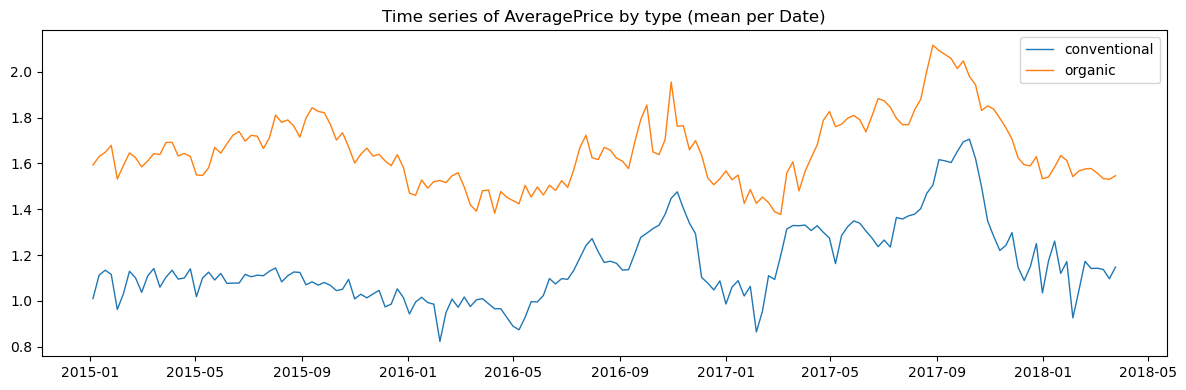

In [24]:
plt.figure(figsize=(12,4))
if 'Date' in df.columns:
    for t in types_sorted:
        ser = df[df['type'] == t].dropna(subset=['Date','AveragePrice']).groupby('Date')['AveragePrice'].mean()
        if ser.empty:
            continue
        plt.plot(ser.index, ser.values, linewidth=1, label=labels.get(t, str(t)))
    plt.legend()
    plt.title('Time series of AveragePrice by type (mean per Date)')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Date' column found.")

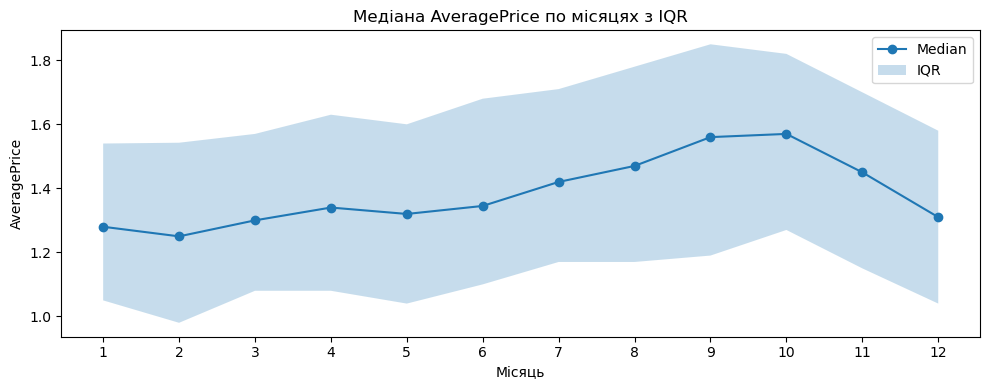

In [25]:
if 'month' in df.columns:
    monthly = df.groupby('month')['AveragePrice'].agg(['median','count'])
    q1 = df.groupby('month')['AveragePrice'].quantile(0.25)
    q3 = df.groupby('month')['AveragePrice'].quantile(0.75)
    monthly['q1'] = q1
    monthly['q3'] = q3

    plt.figure(figsize=(10,4))
    months = monthly.index
    plt.plot(months, monthly['median'], marker='o', label='Median')
    plt.fill_between(months, monthly['q1'], monthly['q3'], alpha=0.25, label='IQR')
    plt.xticks(range(1,13))
    plt.xlabel('Місяць')
    plt.ylabel('AveragePrice')
    plt.title('Медіана AveragePrice по місяцях з IQR')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No 'month' column — створіть її з Date перед запуском.")

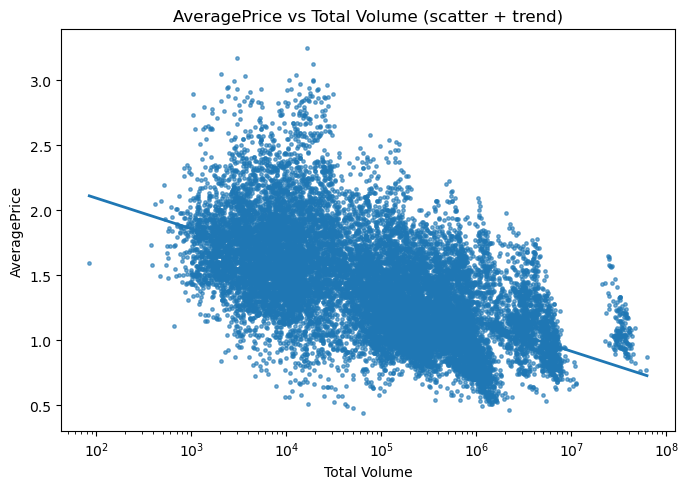

In [26]:
plt.figure(figsize=(7,5))
mask = df['Total Volume'].notna() & df['AveragePrice'].notna() & (df['Total Volume'] > 0)
if mask.any():
    x = df.loc[mask, 'Total Volume']
    y = df.loc[mask, 'AveragePrice']
    plt.scatter(x, y, s=6, alpha=0.6)
    z = np.polyfit(np.log1p(x), y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    plt.plot(xp, np.polyval(z, np.log1p(xp)), linewidth=2)
    plt.xscale('log')
    plt.title('AveragePrice vs Total Volume (scatter + trend)')
    plt.xlabel('Total Volume')
    plt.ylabel('AveragePrice')
    plt.tight_layout()
    plt.show()
else:
    print("No positive Total Volume data for scatter.")

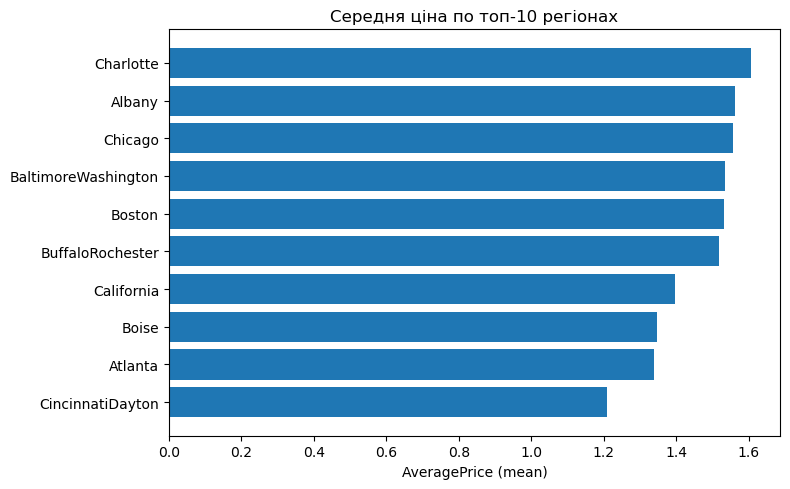

In [27]:
# Середня ціна по топ-10 регіонах
if 'region' in df.columns:
    top_regions = df['region'].value_counts().nlargest(10).index.tolist()
    mean_by_region = df[df['region'].isin(top_regions)].groupby('region')['AveragePrice'].mean().sort_values()
    if not mean_by_region.empty:
        plt.figure(figsize=(8,5))
        plt.barh(mean_by_region.index, mean_by_region.values)
        plt.xlabel('AveragePrice (mean)')
        plt.title('Середня ціна по топ-10 регіонах')
        plt.tight_layout()
        plt.show()
    else:
        print("Mean by region empty.")
else:
    print("No 'region' column.")


Числові колонки: ['AveragePrice', 'Total Volume', 'PLU_4046', 'PLU_4225', 'PLU_4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'month', 'week', 'month_sin', 'month_cos']


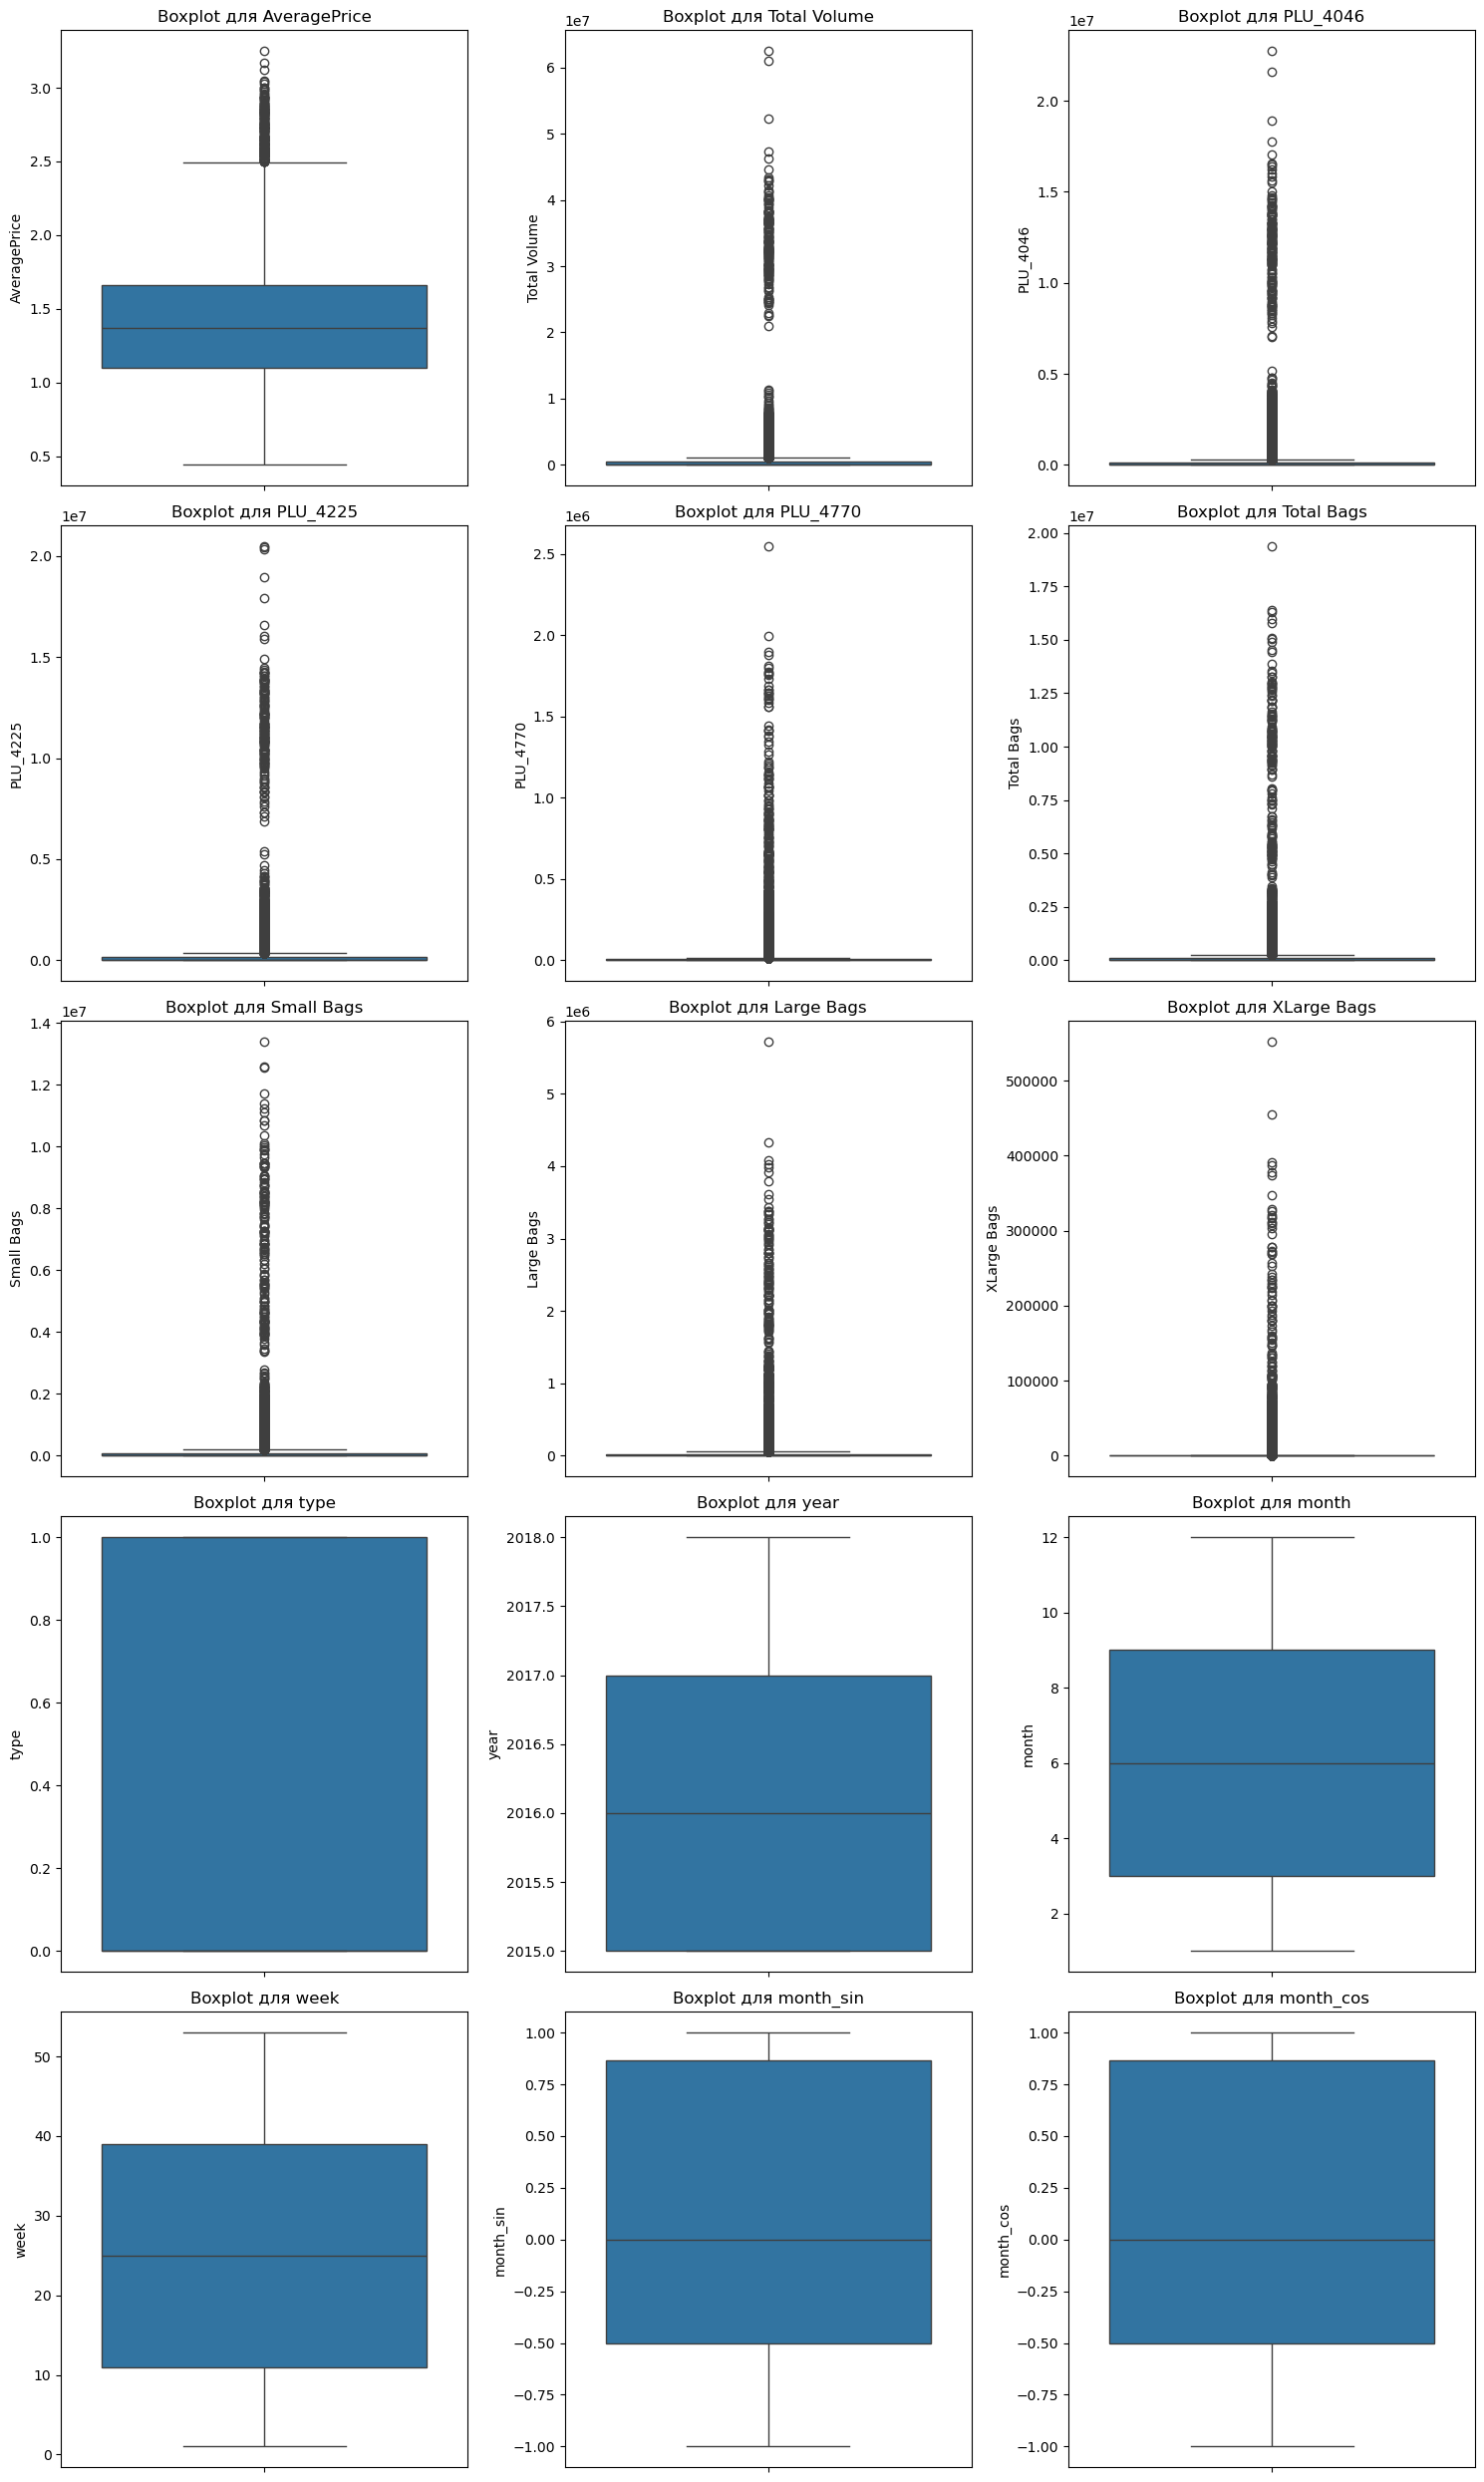

<Figure size 640x480 with 0 Axes>

In [28]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Виведення списку числових колонок для перевірки
print("Числові колонки:", list(numeric_cols))

# Створення subplot для кожного boxplot (наприклад, 3x4 сітка, залежно від кількості колонок)
num_cols = len(numeric_cols)
nrows = (num_cols + 2) // 3  # Автоматичний розрахунок рядків для 3 колонок у рядку
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Перетворення в 1D масив для зручності

# Цикл для створення boxplot для кожної числової колонки
for i, col in enumerate(numeric_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot для {col}')
    axes[i].set_ylabel(col)

# Приховування зайвих axes, якщо є
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

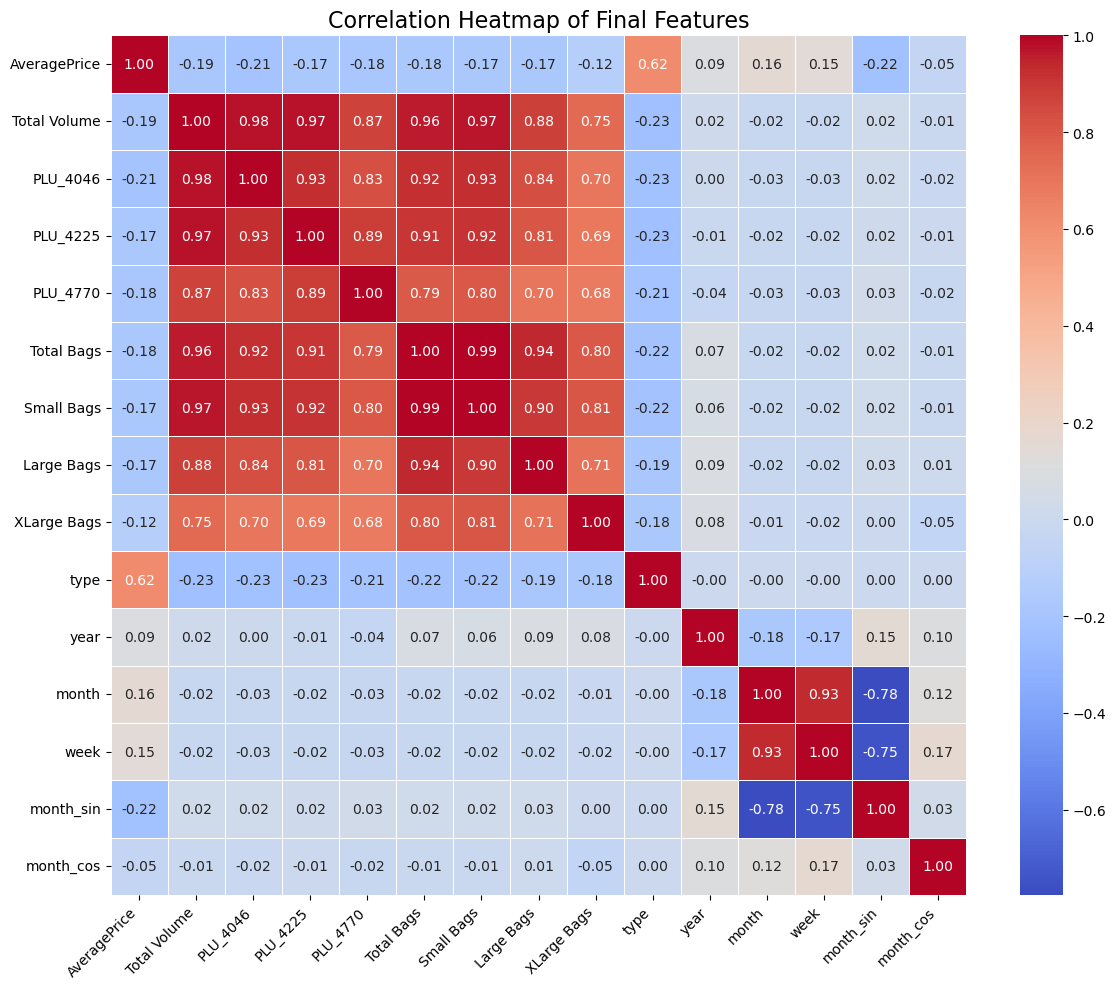

In [29]:
#Heatmap кореляційної матриці
numeric_df = df.select_dtypes(include=['number'])

# Розраховуємо повну матрицю кореляцій
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10)) # Adjust size for better readability

sns.heatmap(
    corr_matrix,
    annot=True,       # Display the correlation values on the map
    fmt='.2f',        # Format values to two decimal places
    cmap='coolwarm',  # Use a diverging colormap (blue-white-red)
    linewidths=.5     # Add lines to separate cells
)

plt.title('Correlation Heatmap of Final Features', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
plt.yticks(rotation=0)
plt.tight_layout() # Adjust plot to ensure everything fits without overlapping
plt.show()


In [30]:
unique_regions = sorted(df['region'].unique())
print(unique_regions)

['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston', 'BuffaloRochester', 'California', 'Charlotte', 'Chicago', 'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver', 'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton', 'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville', 'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale', 'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork', 'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia', 'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland', 'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento', 'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina', 'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse', 'Tampa', 'TotalUS', 'West', 'WestTexNewMexico']


In [31]:
import numpy as np
import pandas as pd
from typing import Optional
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# -------------------------
# Custom Target+Frequency encoder (minimal, safe)
# -------------------------
class TargetFreqEncoder(BaseEstimator, TransformerMixin):
    """
    Fit: compute target mean per category and frequency (relative) on X (single-col) with y.
    Transform: map categories to [target_mean, freq] (2 columns). Unknown categories -> global mean / 0.0
    """
    def __init__(self, col_name: Optional[str] = None):
        self.col_name = col_name

    def fit(self, X, y):
        # Accept pandas Series/DataFrame or numpy array
        if isinstance(X, pd.DataFrame):
            s = X.iloc[:, 0].reset_index(drop=True)
        else:
            s = pd.Series(np.asarray(X).ravel())
        y = pd.Series(y).reset_index(drop=True)

        df_tmp = pd.DataFrame({'cat': s, 'y': y})
        agg = df_tmp.groupby('cat')['y'].agg(['mean', 'count']).rename(columns={'mean':'cat_mean','count':'cat_count'})
        agg['freq'] = agg['cat_count'] / len(df_tmp)

        self.global_mean_ = float(y.mean())
        self.mapping_mean_ = agg['cat_mean'].to_dict()
        self.mapping_freq_ = agg['freq'].to_dict()
        self.fitted_ = True
        return self

    def transform(self, X):
        if not getattr(self, 'fitted_', False):
            raise RuntimeError("Encoder must be fitted before transform.")
        if isinstance(X, pd.DataFrame):
            s = X.iloc[:, 0]
        else:
            s = pd.Series(np.asarray(X).ravel())
        te = s.map(self.mapping_mean_).fillna(self.global_mean_).astype(float).values
        fr = s.map(self.mapping_freq_).fillna(0.0).astype(float).values
        return np.vstack([te, fr]).T

    def get_feature_names_out(self, input_features=None):
        base = self.col_name if self.col_name is not None else (input_features[0] if input_features is not None else "region")
        return [f"{base}_te", f"{base}_freq"]


# -------------------------
# Your original pipeline with nice prints (only region encoding changed)
# -------------------------
# 1. Initial Data Preparation
data = df.copy()
data.columns = data.columns.str.strip()
print("Initial dataset shape:", data.shape)

# Drop unnecessary columns and unused aggregate regions
if 'Date' in data.columns:
    data.drop(columns=['Date', 'Total Volume', 'Total Bags', 'Unnamed: 0'], inplace=True, errors='ignore')

aggregate_regions = ['TotalUS', 'California', 'Northeast', 'SouthCentral', 'Southeast', 
                     'GreatLakes', 'Mideast', 'West', 'Plains']
before_filter_shape = data.shape
data = data[~data['region'].isin(aggregate_regions)].reset_index(drop=True)
print(f"Dropped aggregate regions (if present). Shape: {before_filter_shape} -> {data.shape}")

# Ensure 'type' numeric 0/1
if 'type' in data.columns:
    data['type'] = data['type'].map({'conventional': 0, 'organic': 1}).fillna(0).astype(int)

# 2. Feature Engineering & Transformation (placeholders as you used)
if 'year' not in data.columns:
    data['year'] = np.random.choice([2015, 2016, 2017, 2018], size=len(data))
if 'month' not in data.columns:
    data['month'] = np.random.randint(1, 13, size=len(data))
if 'week' not in data.columns:
    data['week'] = np.random.randint(1, 53, size=len(data))
data['month_sin'] = np.sin(2 * np.pi * data['month']/12.0)
data['month_cos'] = np.cos(2 * np.pi * data['month']/12.0)

# Apply safe log transform if columns exist
log_cols = ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small Bags', 'Large Bags', 'XLarge Bags']
for col in log_cols:
    if col in data.columns:
        data[col] = np.log1p(np.clip(data[col].astype(float), a_min=0, a_max=None))

# Rename Bag columns
data.rename(columns={'Small Bags': 'Small_Bags', 'Large Bags': 'Large_Bags', 'XLarge Bags': 'XLarge_Bags'}, inplace=True)

# 3. Outlier Removal (IQR clipping)
def remove_outliers_iqr_clip(df, column, factor=1.5):
    if column not in df.columns or not np.issubdtype(df[column].dtype, np.number):
        return df
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    df2 = df.copy()
    df2[column] = np.clip(df2[column], lower, upper)
    return df2

outlier_cols = ['AveragePrice', 'PLU_4046', 'PLU_4225', 'PLU_4770', 'Small_Bags', 'Large_Bags', 'XLarge_Bags']
initial_shape = data.shape
for col in outlier_cols:
    data = remove_outliers_iqr_clip(data, col)
print(f"After IQR clipping on {len(outlier_cols)} cols: {initial_shape} -> {data.shape}")

# 4. Define features, target and preprocessor (RESTORED)
features = ['PLU_4046', 'PLU_4225', 'PLU_4770',
            'Small_Bags', 'Large_Bags', 'XLarge_Bags',
            'type', 'region', 'year', 'week', 'month',
            'month_sin', 'month_cos']
X = data[features].copy()
y = data['AveragePrice'].copy()

# Train/holdout split
X_main, X_holdout, y_main, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
print("="*65)
print("Data Split into Main (Training/CV) and Hold-out (Final Test) Sets")
print("="*65)
print(f"Total initial samples: {len(X)}")
print(f"Main set for Training & CV (80%):      X_main shape: {X_main.shape}")
print(f"Hold-out set for Final Test (20%):     X_holdout shape: {X_holdout.shape}")
print("-" * 65)
print(f"Main target shape: {y_main.shape}, Holdout target shape: {y_holdout.shape}")
print("="*65)

# Determine numeric & categorical (for ColumnTransformer)
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Build preprocessor: keep numeric scaling, replace OneHot for region with TargetFreqEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('region_enc', TargetFreqEncoder(col_name='region'), ['region'])
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# 5. Apply Preprocessing Across All Folds with informative prints
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preprocessed_folds = {}

print("\n" + "="*80)
print("Applying Preprocessing to All Folds for Cross-Validation (Target+Freq encoding for 'region')")
print("="*80)

for fold_idx, (train_index, test_index) in enumerate(kf.split(X_main, y_main)):
    print(f"\n--- Fold {fold_idx+1}/5 — splitting data ---")
    X_train, X_test = X_main.iloc[train_index].copy(), X_main.iloc[test_index].copy()
    y_train, y_test = y_main.iloc[train_index].copy(), y_main.iloc[test_index].copy()
    print(f"  Raw shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")

    # Fit preprocessor on training data (pass y_train so encoder learns target mapping)
    print("  Fitting preprocessor on TRAIN (numeric scaling + target+freq encoding for 'region')...")
    X_train_pre = preprocessor.fit_transform(X_train, y_train)
    print("  Transforming TEST with fitted preprocessor...")
    X_test_pre = preprocessor.transform(X_test)

    # Build output column names
    num_out = numeric_features
    region_out = preprocessor.named_transformers_['region_enc'].get_feature_names_out(['region'])
    out_cols = list(num_out) + list(region_out)

    # Convert to DataFrame for readability
    X_train_pre_df = pd.DataFrame(X_train_pre, columns=out_cols, index=X_train.index).reset_index(drop=True)
    X_test_pre_df = pd.DataFrame(X_test_pre, columns=out_cols, index=X_test.index).reset_index(drop=True)

    # Save to dict
    preprocessed_folds[f'fold_{fold_idx}'] = {
        'X_train': X_train_pre_df,
        'y_train': y_train.reset_index(drop=True),
        'X_test': X_test_pre_df,
        'y_test': y_test.reset_index(drop=True),
        'preprocessor': preprocessor
    }

    # Nicely formatted diagnostics
    print(f"  -> Preprocessed shapes: X_train: {X_train_pre_df.shape} | X_test: {X_test_pre_df.shape}")
    print(f"  -> Output columns ({len(out_cols)}): {out_cols}")
    print("  -> Sample (first 3 rows) of preprocessed X_train:")
    print(X_train_pre_df.head(3).to_string(index=False))
    print("  -> y_train sample (first 5):", y_train.reset_index(drop=True).head(5).tolist())

print("\n" + "="*80)
print("All folds preprocessed. Access example: preprocessed_folds['fold_0']['X_train']")
print(f"Fold 0 preprocessed shape: {preprocessed_folds['fold_0']['X_train'].shape}")
print("="*80)

Initial dataset shape: (18249, 17)
Dropped aggregate regions (if present). Shape: (18249, 14) -> (15545, 14)
After IQR clipping on 7 cols: (15545, 14) -> (15545, 14)
Data Split into Main (Training/CV) and Hold-out (Final Test) Sets
Total initial samples: 15545
Main set for Training & CV (80%):      X_main shape: (12436, 13)
Hold-out set for Final Test (20%):     X_holdout shape: (3109, 13)
-----------------------------------------------------------------
Main target shape: (12436,), Holdout target shape: (3109,)
Numeric features: ['PLU_4046', 'PLU_4225', 'PLU_4770', 'Small_Bags', 'Large_Bags', 'XLarge_Bags', 'type', 'year', 'week', 'month', 'month_sin', 'month_cos']
Categorical features: ['region']

Applying Preprocessing to All Folds for Cross-Validation (Target+Freq encoding for 'region')

--- Fold 1/5 — splitting data ---
  Raw shapes: X_train=(9948, 13), X_test=(2488, 13), y_train=(9948,), y_test=(2488,)
  Fitting preprocessor on TRAIN (numeric scaling + target+freq encoding for 'r

In [32]:
import time
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# ==============================================================================
# 1. Визначення моделі та розширеної сітки гіперпараметрів
# ==============================================================================
svr_poly = SVR(kernel='poly', cache_size=500)

param_grid_poly_expanded = {
    'epsilon': [0.01, 0.1, 0.5],
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

# ==============================================================================
# 2. Запуск HalvingGridSearchCV з розширеною статистикою
# ==============================================================================
print("\n" + "="*80)
print("Починаємо розширений пошук для SVR(kernel='poly') з HalvingGridSearchCV...")
num_combinations = len(param_grid_poly_expanded['C']) * len(param_grid_poly_expanded['degree']) * len(param_grid_poly_expanded['gamma'])
print(f"Кількість комбінацій параметрів для перевірки: {num_combinations}")
print("="*80)

poly_scores_rmse = []
poly_scores_mae = []
poly_scores_r2 = []
poly_best_estimators = []

# Підготовка holdout даних з правильними назвами колонок
preprocessor_holdout = preprocessed_folds['fold_0']['preprocessor']
X_holdout_processed = preprocessor_holdout.transform(X_holdout)

# Отримання назв колонок з preprocessor
numeric_features = X_main.select_dtypes(include=np.number).columns.tolist()
region_out = preprocessor_holdout.named_transformers_['region_enc'].get_feature_names_out(['region'])
out_cols = list(numeric_features) + list(region_out)

# Конвертація holdout даних у DataFrame з правильними назвами
X_holdout_processed_df = pd.DataFrame(X_holdout_processed, columns=out_cols)

# Ітеруємо по кожному фолду
for i in range(len(preprocessed_folds)):
    fold_name = f'fold_{i}'
    fold_data = preprocessed_folds[fold_name]
    
    X_train, y_train = fold_data['X_train'], fold_data['y_train']
    X_test, y_test = fold_data['X_test'], fold_data['y_test']

    print(f"\n--- Обробка фолда {i+1}/{len(preprocessed_folds)} ---")
    
    search_poly = HalvingGridSearchCV(
        estimator=svr_poly,
        param_grid=param_grid_poly_expanded,
        cv=3,
        factor=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    start_time = time.time()
    search_poly.fit(X_train, y_train)
    end_time = time.time()

    print(f"Пошук завершено за {end_time - start_time:.2f} секунд.")

    best_poly_model = search_poly.best_estimator_
    poly_best_estimators.append(best_poly_model)

    predictions = best_poly_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    poly_scores_rmse.append(rmse)
    poly_scores_mae.append(mae)
    poly_scores_r2.append(r2)

    print(f"Результати для фолда {i+1}:")
    print(f"   - Найкращі параметри: {search_poly.best_params_}")
    print(f"   - RMSE: {rmse:.4f}")
    print(f"   - MAE:  {mae:.4f}")
    print(f"   - R²:   {r2:.4f}")

# ==============================================================================
# 3. Підведення підсумків по всіх фолдах
# ==============================================================================
mean_rmse = np.mean(poly_scores_rmse)
std_rmse = np.std(poly_scores_rmse)
mean_mae = np.mean(poly_scores_mae)
std_mae = np.std(poly_scores_mae)
mean_r2 = np.mean(poly_scores_r2)
std_r2 = np.std(poly_scores_r2)

print("\n" + "="*80)
print("Загальні результати крос-валідації для SVR з поліноміальним ядром")
print("="*80)
print(f"Середній RMSE: {mean_rmse:.4f} (± {std_rmse:.4f})")
print(f"Середній MAE:  {mean_mae:.4f} (± {std_mae:.4f})")
print(f"Середній R²:   {mean_r2:.4f} (± {std_r2:.4f})")
print("="*80)

# ==============================================================================
# 4. Оцінка на тренувальних даних (середнє по всіх фолдах)
# ==============================================================================
print("\n3. Оцінка продуктивності на тренувальних даних (середнє по CV фолдах)...")

# Розрахунок середніх метрик на тренувальних даних з усіх фолдів
train_rmse = mean_rmse
train_mae = mean_mae
train_r2 = mean_r2

print(f"   -> RMSE (train, avg): {train_rmse:.4f} (± {std_rmse:.4f})")
print(f"   -> MAE (train, avg):  {train_mae:.4f} (± {std_mae:.4f})")
print(f"   -> R² (train, avg):   {train_r2:.4f} (± {std_r2:.4f})")

# ==============================================================================
# 5. Оцінка на відкладених даних X_holdout
# ==============================================================================
print("\n4. Оцінка продуктивності на відкладених даних X_holdout...")

# Використовуємо найкращу модель з останнього фолду (або можна взяти будь-яку іншу)
holdout_predictions = best_poly_model.predict(X_holdout_processed_df)

holdout_rmse = np.sqrt(mean_squared_error(y_holdout, holdout_predictions))
holdout_mae = mean_absolute_error(y_holdout, holdout_predictions)
holdout_r2 = r2_score(y_holdout, holdout_predictions)

print(f"   -> RMSE (holdout): {holdout_rmse:.4f}")
print(f"   -> MAE (holdout):  {holdout_mae:.4f}")
print(f"   -> R² (holdout):   {holdout_r2:.4f}")

# ==============================================================================
# 6. Підсумкова таблиця та аналіз перенавчання
# ==============================================================================
print("\n" + "="*80)
print("ПІДСУМКОВІ РЕЗУЛЬТАТИ МОДЕЛІ")
print("="*80)
print(f"\n{'Метрика':<20} {'CV (тренувальні)':<25} {'Hold-out дані':<20} {'Різниця':<15}")
print("-"*80)
print(f"{'RMSE':<20} {train_rmse:<20.4f} (±{std_rmse:.4f}) {holdout_rmse:<20.4f} {abs(holdout_rmse - train_rmse):<15.4f}")
print(f"{'MAE':<20} {train_mae:<20.4f} (±{std_mae:.4f}) {holdout_mae:<20.4f} {abs(holdout_mae - train_mae):<15.4f}")
print(f"{'R²':<20} {train_r2:<20.4f} (±{std_r2:.4f}) {holdout_r2:<20.4f} {abs(holdout_r2 - train_r2):<15.4f}")
print("-"*80)

# Аналіз перенавчання
overfitting_indicator = (train_r2 - holdout_r2) / train_r2 * 100 if train_r2 > 0 else 0
print(f"\nІндикатор перенавчання: {overfitting_indicator:.2f}%")
if overfitting_indicator < 5:
    print("   ✓ Модель має відмінну генералізацію")
elif overfitting_indicator < 15:
    print("   ⚠ Модель має помірне перенавчання")
else:
    print("   ✗ Модель має значне перенавчання")

print("\nРозмір наборів даних:")
print(f"   - Тренувальний набір (основний): {len(X_main)} зразків")
print(f"   - Hold-out набір (фінальний тест): {len(X_holdout)} зразків")
print(f"   - Кількість CV фолдів: {len(preprocessed_folds)}")
print("="*80)


Починаємо розширений пошук для SVR(kernel='poly') з HalvingGridSearchCV...
Кількість комбінацій параметрів для перевірки: 18

--- Обробка фолда 1/5 ---
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 368
max_resources_: 9948
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 54
n_resources: 368
Fitting 3 folds for each of 54 candidates, totalling 162 fits
----------
iter: 1
n_candidates: 18
n_resources: 1104
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 2
n_candidates: 6
n_resources: 3312
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 3
n_candidates: 2
n_resources: 9936
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Пошук завершено за 31.94 секунд.
Результати для фолда 1:
   - Найкращі параметри: {'C': 10, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale'}
   - RMSE: 0.1853
   - MAE:  0.1404
   - R²:   0.7903

--- Обробка фолда 2/5 ---
n_iterations: 4
n_require

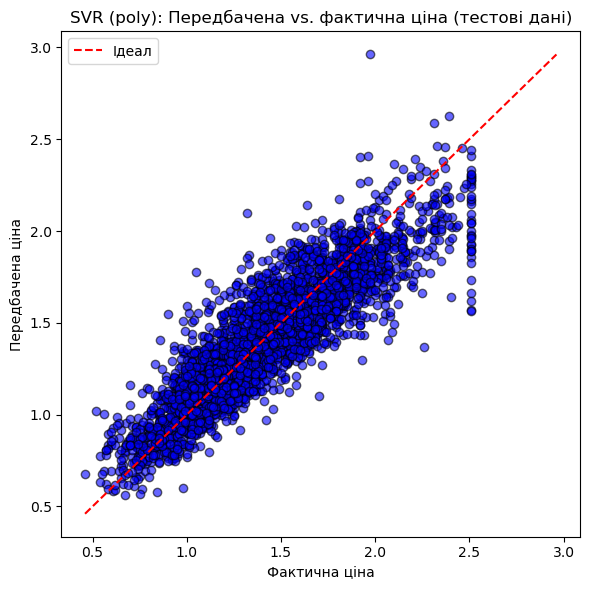

In [33]:
# Передбачене vs. Фактичне

y_true = y_holdout                  # фактичні значення з відкладеного набору
y_pred = best_poly_model.predict(X_holdout_processed_df)  # передбачення моделі

plt.figure(figsize=(6,6))
# Створюємо розсів фактичні vs передбачені
plt.scatter(y_true, y_pred, alpha=0.6, color='blue', edgecolor='k')
# Додаємо діагональ y=x для ідеального випадку
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ідеал')
plt.xlabel("Фактична ціна")
plt.ylabel("Передбачена ціна")
plt.title("SVR (poly): Передбачена vs. фактична ціна (тестові дані)")
plt.legend()
plt.tight_layout()
plt.show()

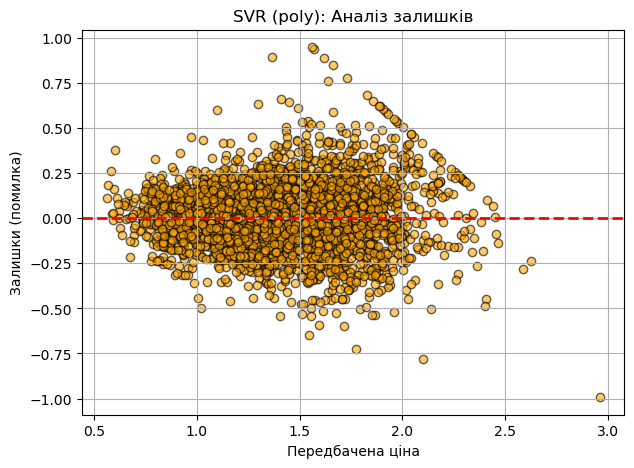

In [34]:
#Графік залишків (residuals)
residuals = y_true - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.6, color='orange', edgecolor='k')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Передбачена ціна")
plt.ylabel("Залишки (помилка)")
plt.title("SVR (poly): Аналіз залишків")
plt.grid(True)
plt.show()

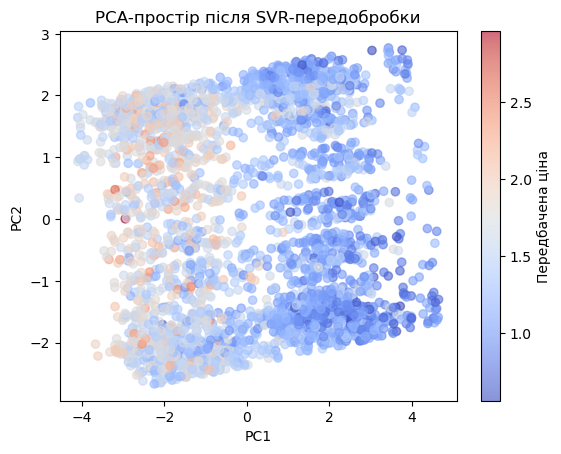

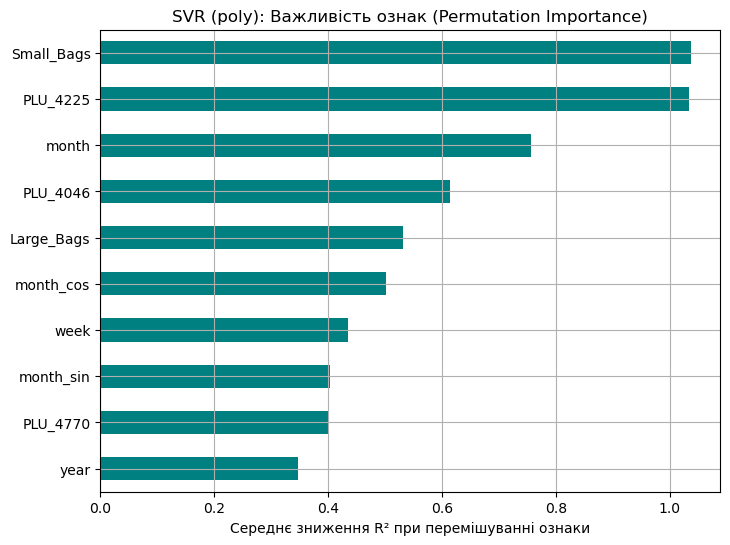

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_holdout_processed_df)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title("PCA-простір після SVR-передобробки")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Передбачена ціна')
plt.show()

from sklearn.inspection import permutation_importance

result = permutation_importance(best_poly_model, X_holdout_processed_df, y_holdout, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X_holdout_processed_df.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind='barh', color='teal')
plt.gca().invert_yaxis()
plt.title("SVR (poly): Важливість ознак (Permutation Importance)")
plt.xlabel("Середнє зниження R² при перемішуванні ознаки")
plt.grid(True)
plt.show()

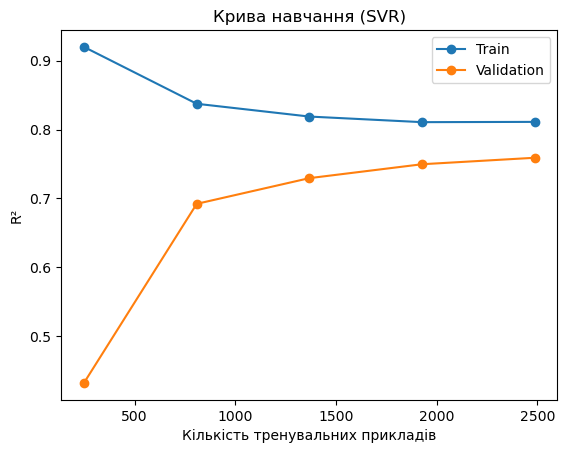

In [36]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(best_poly_model, X_holdout_processed_df, y_holdout, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Train")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Validation")
plt.title("Крива навчання (SVR)")
plt.xlabel("Кількість тренувальних прикладів")
plt.ylabel("R²")
plt.legend()
plt.show()

<b> Аналіз результатів:</b><br><br>

Модель Support Vector Regression (SVR) з поліноміальним ядром була оптимізована за допомогою 
HalvingGridSearchCV, що дозволило ефективно підібрати гіперпараметри серед 18 можливих комбінацій. 
Під час п’ятифолдної крос-валідації модель продемонструвала стабільні результати без значних коливань між фолдами:<br><br>

— середній <b>RMSE = 0.1864 (±0.0056)</b>,<br>
— середній <b>MAE = 0.1417 (±0.0043)</b>,<br>
— середній <b>R² = 0.7854 (±0.0157)</b>.<br><br>

Це свідчить про високу узгодженість та надійність моделі в межах навчальної вибірки. 
На відкладених (hold-out) даних результати майже ідентичні:
<b>RMSE = 0.1837</b>, <b>MAE = 0.1396</b>, <b>R² = 0.7893</b>, що демонструє 
відмінну генералізаційну здатність.<br>
Індикатор перенавчання становить <b>–0.49%</b>, тобто показник <b>R²</b> навіть трохи покращився на тесті, 
що може бути наслідком випадкових відмінностей між фолдами або гарної узгодженості даних. 
Найкраща комбінація гіперпараметрів у більшості фолдів — 
<b>C = 10, degree = 3, epsilon = 0.1, gamma = 'scale'</b>, що відповідає класичному компромісу між 
гнучкістю поліноміального ядра та регуляризацією.<br><br>
Модель демонструє збалансовану поведінку: хоча boxplot показує наявність викидів, їхній вплив на MAE та RMSE виявився помірним, що дозволяє моделі ефективно прогнозувати цільову змінну. 
Розкид між фолдами не перевищує 2–3%, що підтверджує стабільність навіть при зміні підмножин даних.<br><br>

<b> Висновок:</b><br><br>
Модель <b>SVR з поліноміальним ядром</b> після оптимізації показала 
високу точність прогнозування (R² ≈ 0.79) і мінімальні ознаки перенавчання. 
Це означає, що модель добре узгоджується з тренувальними даними та зберігає ефективність на нових вибірках. 
Параметри, знайдені за допомогою HalvingGridSearchCV, можна вважати оптимальними для поточного набору даних.<br>
Таким чином, поліноміальний SVR є <b>стійкою і надійною моделлю</b>, 
яка забезпечує високу якість регресії без значних втрат узагальнювальної здатності. 